### Automatically detect and model the background emission using LUCI
In this notebook, we will demonstrate the tools in LUCI to detect and model the background.

To do this, we apply the following steps:
1) Use a segmentation algorithm to find the background pixels
2) Use PCA to construct a subspace representing the background component
    - This includes the sky lines
3) Project each background pixel into a truncated PCA space
4) Interpolate masked pixels into PCA space
    - This can be done by either standard interpolation or using an artificial neural network

All of these steps have been wrapped into a single LUCI call for convenience. Implementation details can be found in our article.

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('/home/carterrhea/Documents/LUCI/light.mplstyle')

In [2]:
# Define user-specific variables
n_components = 50  # Number of PCA components to calculate
n_components_keep = 3  # Number of PCA components to keep
outputDir = '/export/home/carterrhea/NGC4449'  # Output directory for plots and data
Luci_path = '/home/carterrhea/Documents/LUCI/'
cube_dir = '/export/home/carterrhea/NGC4449'  # Path to data cube
cube_name = 'NGC4449_SN3'  # don't add .hdf5 extension
object_name = 'NGC4449'
redshift = 0.0004  # Redshift
resolution = 5000

path = os.path.abspath(Luci_path)
sys.path.insert(0, path)  # add LUCI to the available paths
plt.style.use(os.path.join(Luci_path, 'light.mplstyle'))
from LuciBase import Luci

/home/carterrhea/anaconda3/envs/luci/lib/python3.9/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "
2023-07-25 15:35:39.119542: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-25 15:35:39.310334: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/src/heasoft-6.31.1/x86_64-pc-linux-gnu-libc2.35/lib
2023-07-25 15:35:39.31036

In [3]:
cube = Luci(Luci_path, cube_dir+'/'+cube_name, cube_dir, object_name, redshift, resolution, mdn=False)


Reading in data...


100%|█████████████████████████████████████████████| 9/9 [00:44<00:00,  4.95s/it]


Existing deep frame extracted from hdf5 file.


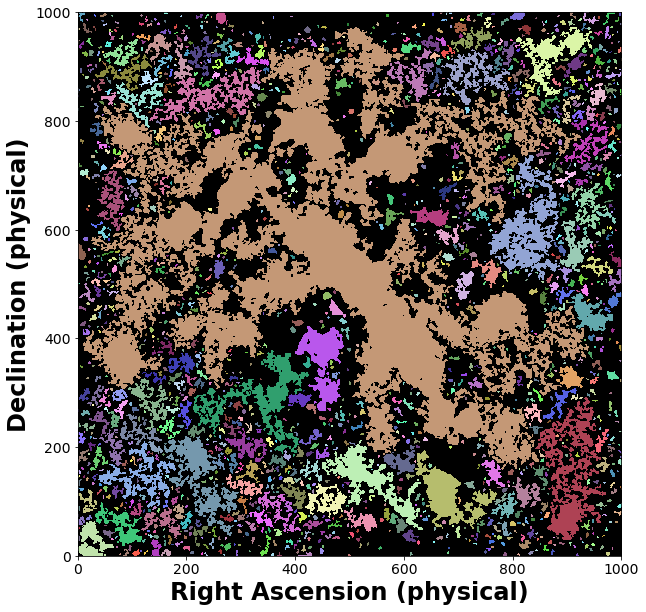

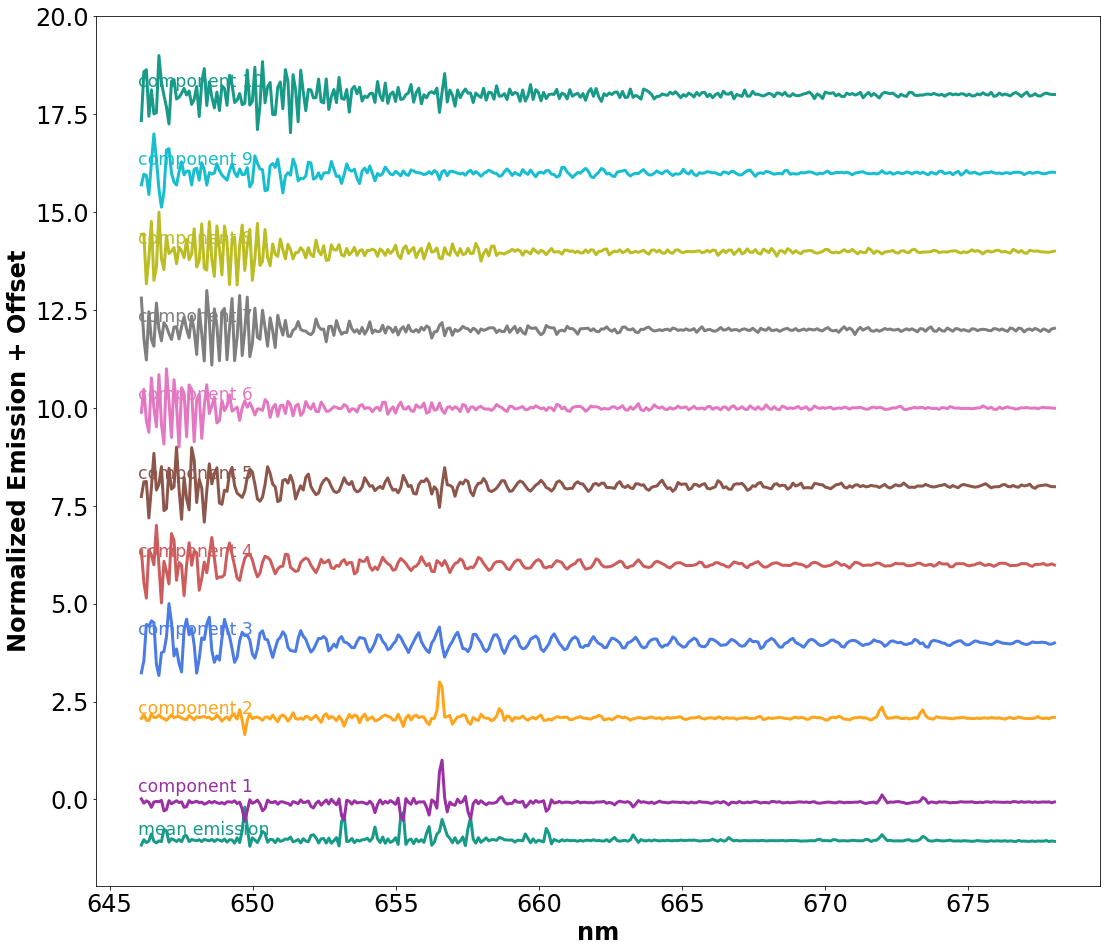

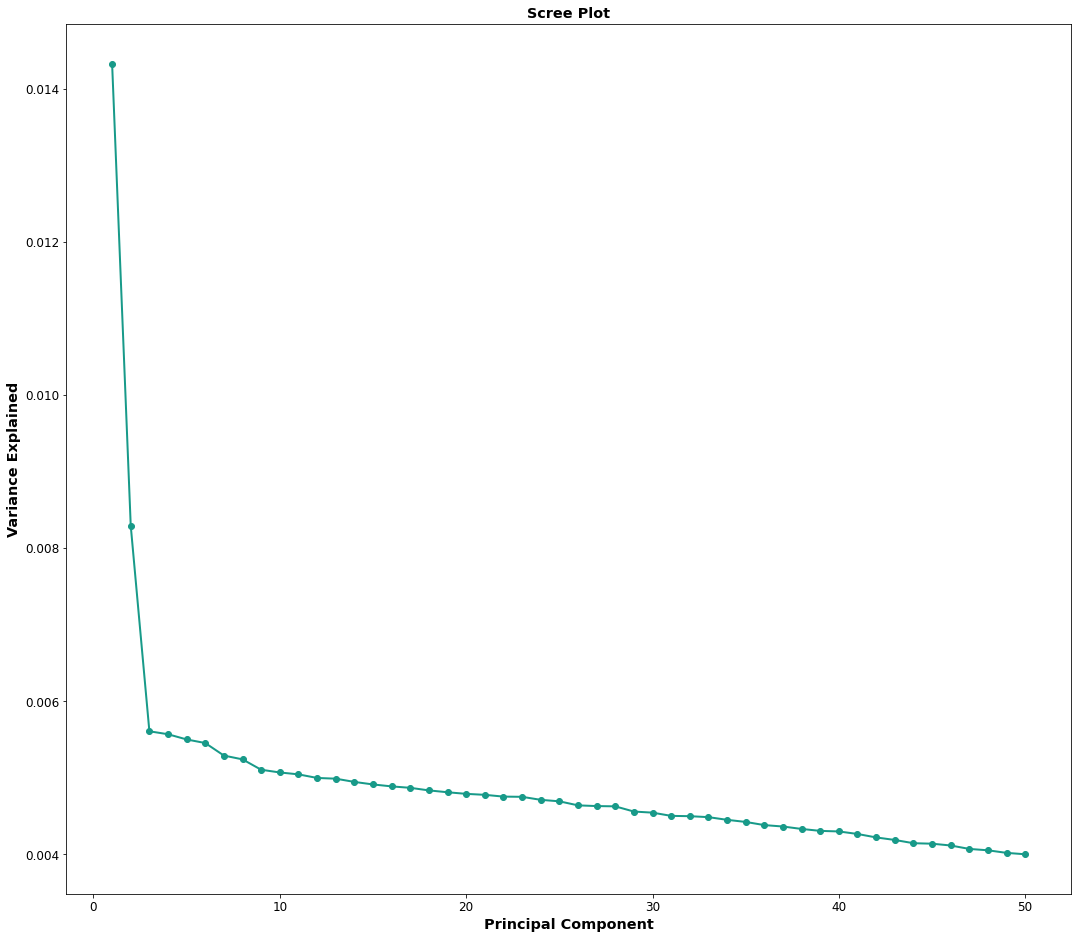

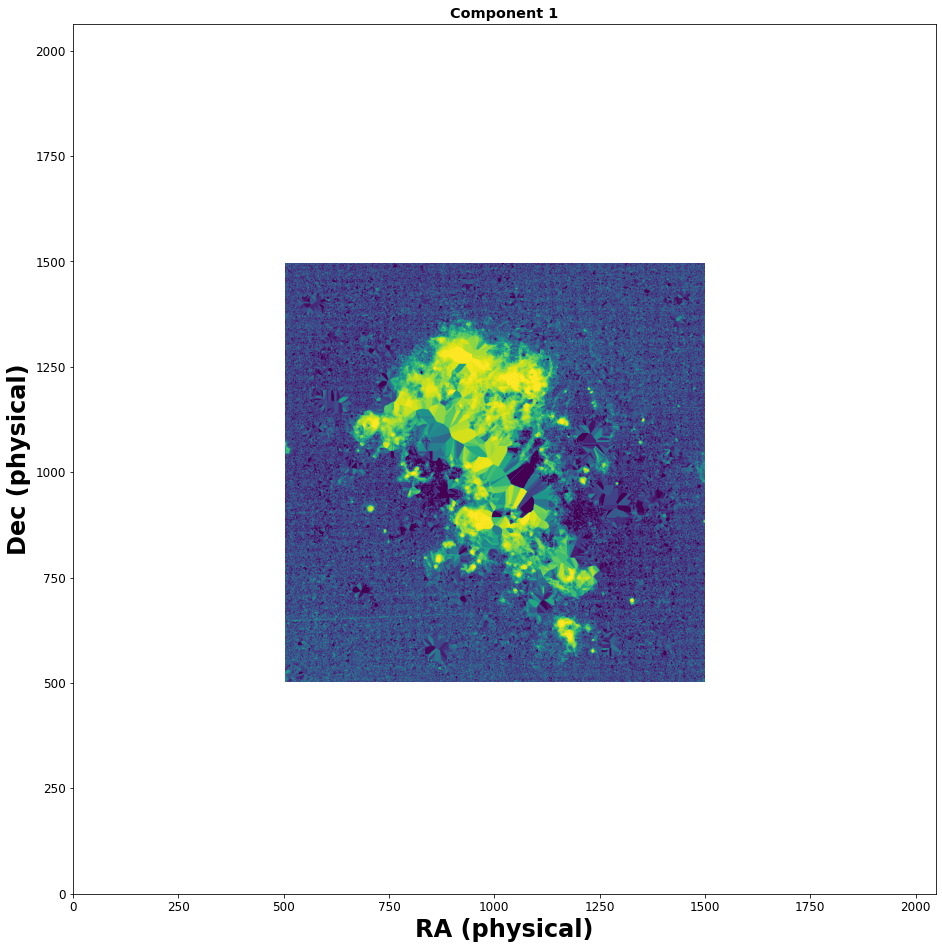

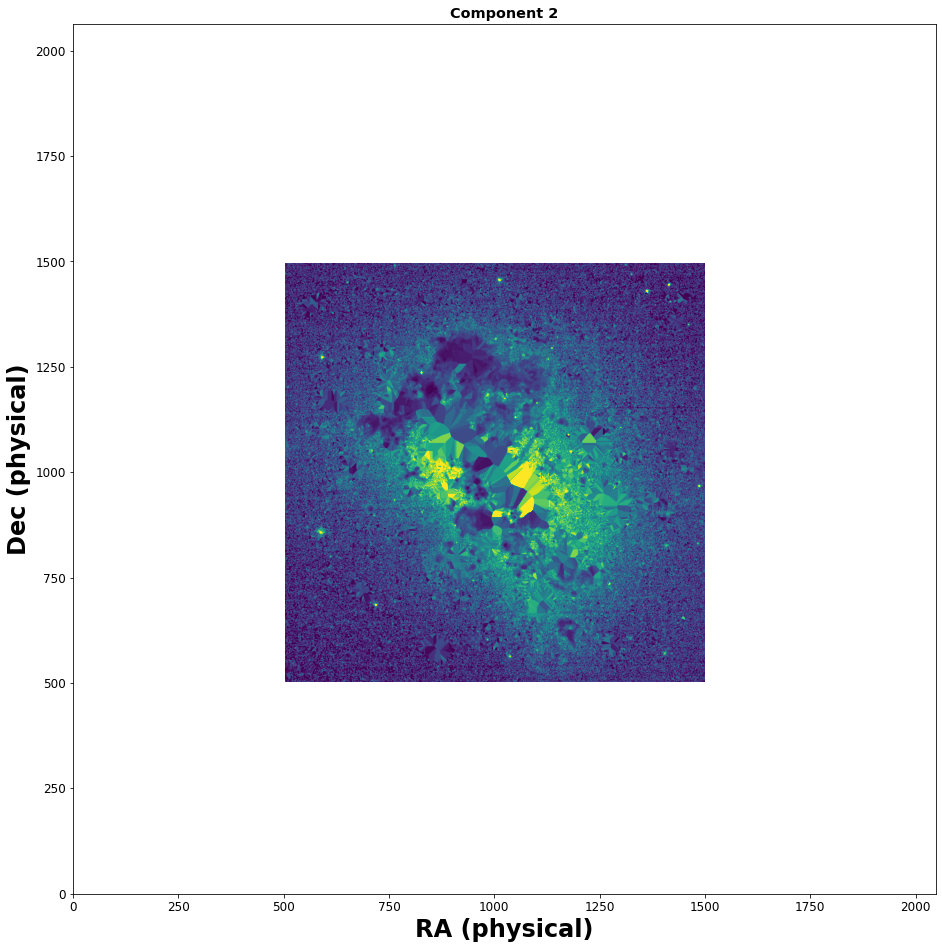

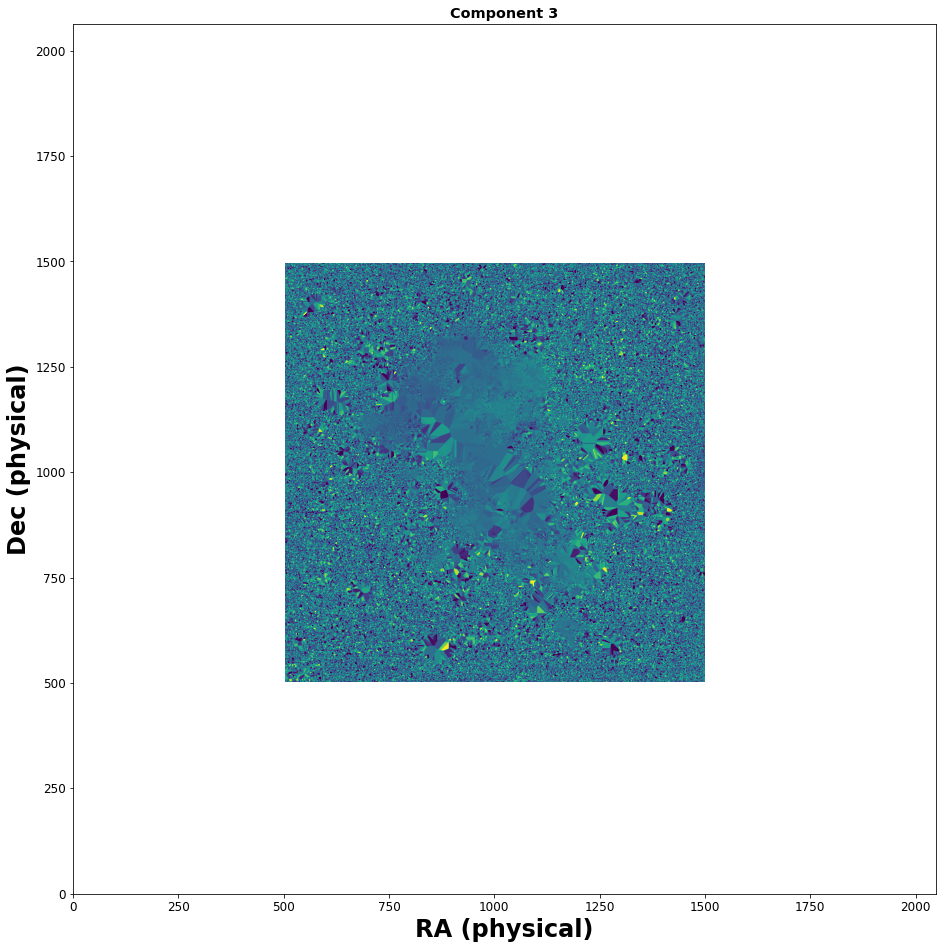

In [4]:
BkgTransformedPCA, pca, interpolatedSourcePixels, idx_bkg, idx_src, coefficient_array = cube.create_background_subspace(x_min=500, x_max=1500, y_min=500, y_max=1500, 
                                                                                                     n_components=n_components, n_components_keep=n_components_keep)

In [5]:
np.nanstd(interpolatedSourcePixels[:,])

0.5640279997303695

In [6]:
import pickle
pickle.dump(idx_bkg, open('/export/home/carterrhea/NGC4449/idx_bkg.pkl', 'wb'))
pickle.dump(idx_src, open('/export/home/carterrhea/NGC4449/idx_src.pkl', 'wb'))
pickle.dump(cube.spectrum_axis, open('/export/home/carterrhea/NGC4449/spectrum_axis.pkl', 'wb'))
pickle.dump(BkgTransformedPCA, open('/export/home/carterrhea/NGC4449/BkgTransformedPCA.pkl', 'wb'))

#pickle.dump(cube.cube_final, open('/export/home/carterrhea/NGC4449/cube_final.pkl','wb'))

In [7]:
import numpy as np

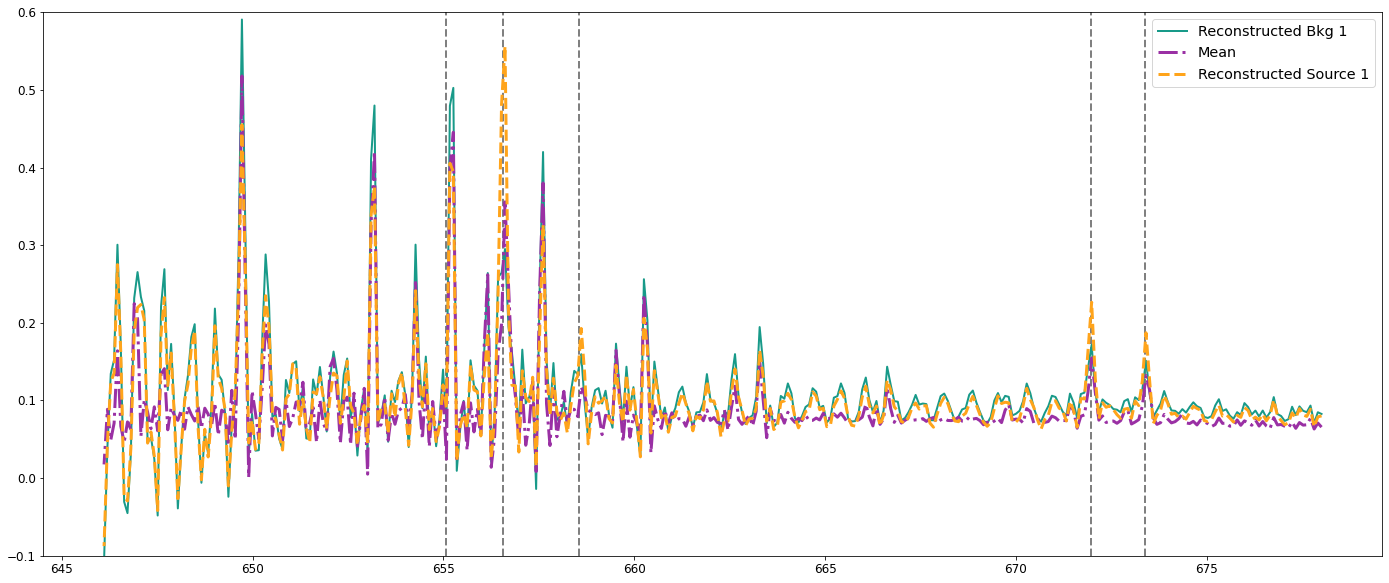

In [8]:
plt.figure(figsize=(24,10))
max_spectral = np.argmin(np.abs([1e7 / wavelength - 646 for wavelength in cube.spectrum_axis]))
min_spectral = np.argmin(np.abs([1e7 / wavelength - 678 for wavelength in cube.spectrum_axis]))
plt.plot(1e7/cube.spectrum_axis[min_spectral: max_spectral], pca.mean_-np.sum([pca.components_[i] * BkgTransformedPCA[0,i] for i in range(n_components_keep)], axis=0), label='Reconstructed Bkg 1')
plt.plot(1e7/cube.spectrum_axis[min_spectral: max_spectral], pca.mean_, linewidth=3, linestyle='-.', label='Mean')
plt.plot(1e7/cube.spectrum_axis[min_spectral: max_spectral],
         pca.mean_ - np.sum([pca.components_[i] * interpolatedSourcePixels[10][i] for i in range(n_components_keep)], axis=0),
         linewidth=3, linestyle='--', label='Reconstructed Source 1')
plt.vlines((654.8*(1+redshift), 656.3*(1+redshift), 658.3*(1+redshift), 671.7*(1+redshift), 673.1*(1+redshift)), -0.1, 0.65, linestyle='--', color='grey')
#plt.vlines(656.3*(1+redshift), -.1, 0.6, label='Halpha', linestyle='-', color='grey', linewidth=3)
#plt.vlines(654.8*(1+redshift), -.1, 0.6, label='NII6548', linestyle='-', color='grey', linewidth=3)
#plt.vlines(658.4*(1+redshift), -.1, 0.6, label='NII6584', linestyle='-', color='grey', linewidth=3)
#plt.vlines(671.7*(1+redshift), -.1, 0.6, label='SII6717', linestyle='-', color='grey', linewidth=3)
#plt.vlines(673.1*(1+redshift), -.1, 0.6, label='SII6731', linestyle='-', color='grey', linewidth=3)
plt.ylim(-0.1, 0.6)
plt.legend()
plt.savefig('/export/home/carterrhea/NGC4449/Backgrounds.png')

In [9]:
np.std([val[0] for val in interpolatedSourcePixels])

0.702622811037955

(array([5.00000e+00, 3.10000e+01, 8.20000e+01, 1.38700e+03, 4.90550e+04,
        2.75975e+05, 1.52782e+05, 3.23180e+04, 3.67690e+04, 3.20100e+03]),
 array([-3.82422552, -3.18957411, -2.5549227 , -1.92027129, -1.28561989,
        -0.65096848, -0.01631707,  0.61833434,  1.25298574,  1.88763715,
         2.52228856]),
 <BarContainer object of 10 artists>)

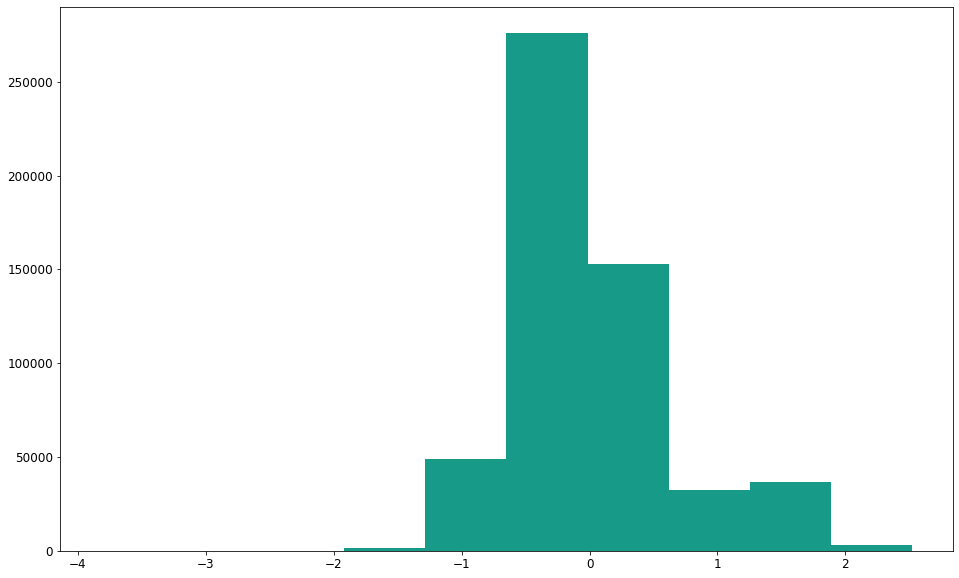

In [10]:
plt.hist([val[0] for val in BkgTransformedPCA])

In [ ]:
cube.fit_cube(['Halpha', 'NII6583', 'NII6548'], 
                 'sinc', 
                 [1,1,1], [1,1,1],
                 #950, 1100, 950, 1100, 
                  600, 1540, 500, 1500,
                 spec_min= 15000, spec_max = 15500,
                 bkgType='pca', n_threads=40, binning=1, bayes_bool=False, n_stoch=1,
                 pca_coefficient_array=coefficient_array, pca_vectors=pca.components_, pca_mean=pca.mean_
             )

  4%|█▋                                       | 40/1000 [00:20<08:00,  2.00it/s]/home/carterrhea/anaconda3/envs/luci/lib/python3.9/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "
/home/carterrhea/anaconda3/envs/luci/lib/python3.9/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "
/home/carterrhea/anaconda3/envs/luci/lib/python3.9/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this versio